In [69]:
import pandas as pd

data_source = './data/beer_profile_and_ratings.csv'

#df = pd.read_csv(data_source)
df = pd.read_table(data_source, delimiter=',')
def trim_style(style):
    if '-' in style:
        return style.split('-')[0].strip()
    return style

df['Style'] = df['Style'].apply(trim_style)
unique_styles = df['Style'].unique()

df.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


In [70]:
import numpy as np
from scipy.stats import chi2

numeric_features = ['ABV', 'Min IBU', 'Max IBU']

def mahalanobis_dist(df, features):
    X = df[features].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov)  # Используем псевдообратную матрицу если обычная вырождена
    
    deviations = X - mean
    distances = np.sqrt(np.sum(deviations.dot(cov_inv) * deviations, axis=1))
    return distances

# Вычисляем расстояния
distances = mahalanobis_dist(df, numeric_features)

# Определяем порог с использованием хи-квадрат распределения
threshold = chi2.ppf(0.95, df=len(numeric_features))  # 95% доверительный интервал

# Находим индексы выбросов
outliers_mask = distances > np.sqrt(threshold)
outliers = df[outliers_mask]

original_size = len(df)
df_clean = df[~outliers_mask]

df = df_clean.copy()

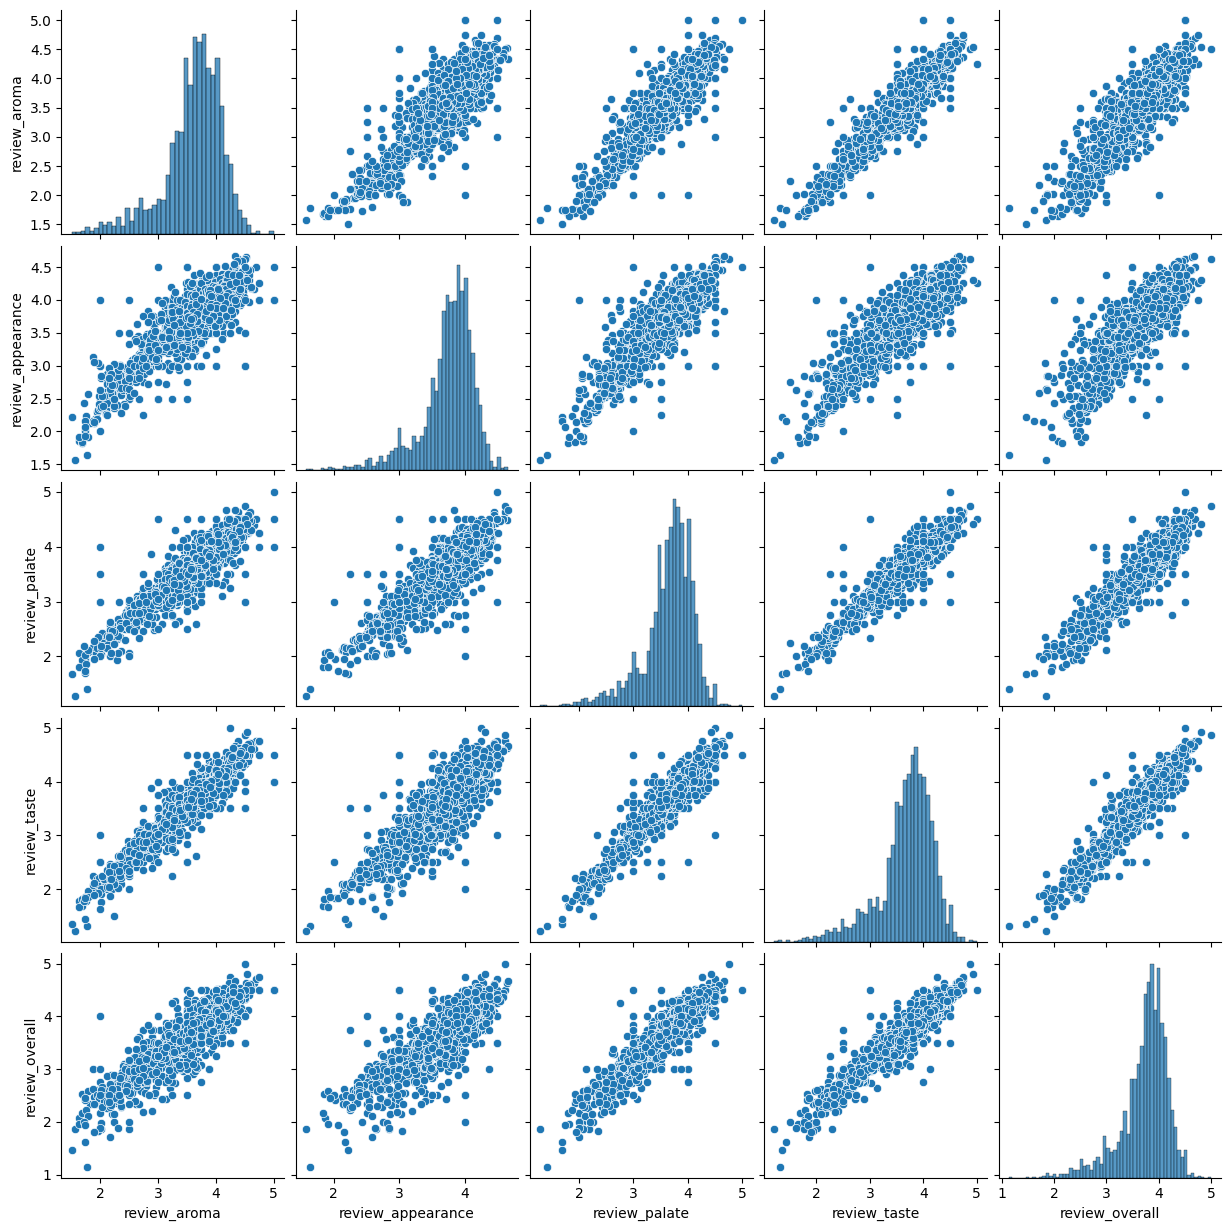

In [71]:
import seaborn as sb
%matplotlib inline

sb.pairplot(df, vars=['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall'])

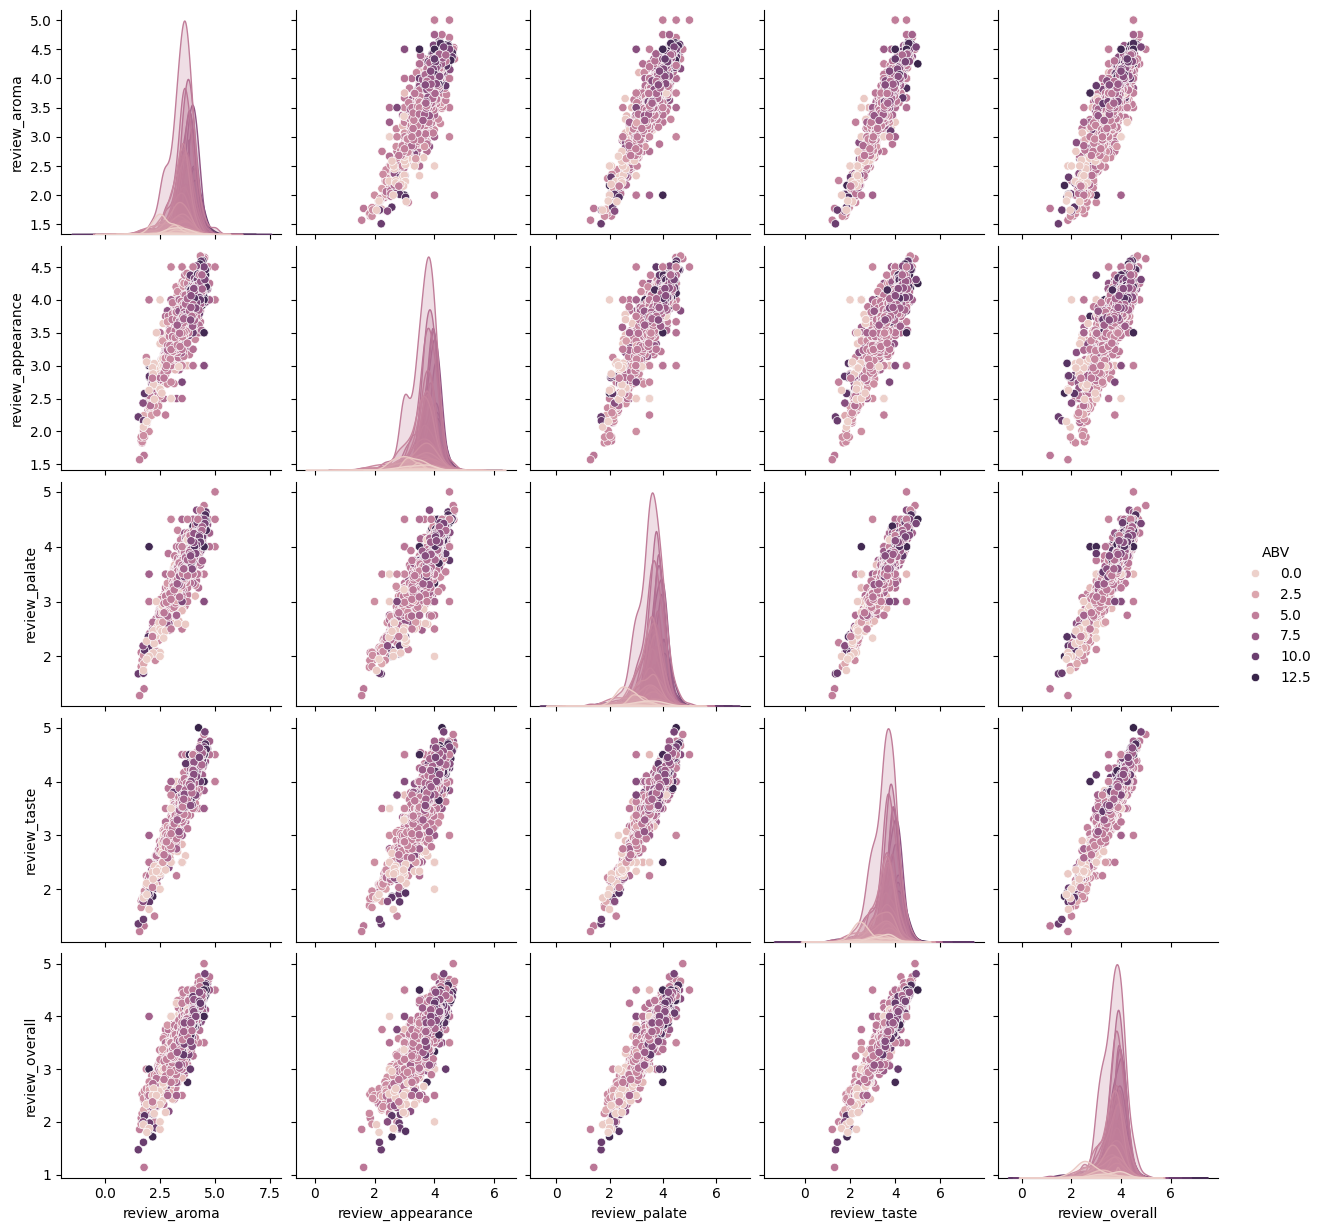

In [72]:
sb.pairplot(df, vars=['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall'], hue='ABV')

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Выбор признаков и целевой переменной
features = ['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
            'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']
X = df[features]  # Признаки
y = df['Style']   # Целевая переменная (стиль пива)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = knn.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy:.2f}')

Точность модели: 0.54


In [74]:
from sklearn.model_selection import train_test_split

x_train, x_holdout, y_train, y_holdout = train_test_split(df[['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
            'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']], 
            df['Style'], 
            test_size=0.3,
            random_state=17)
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_holdout)
accur = accuracy_score(y_holdout, knn_pred)
print('accuracy: ', accur)

accuracy:  0.5383747178329571


C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\fatop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\si

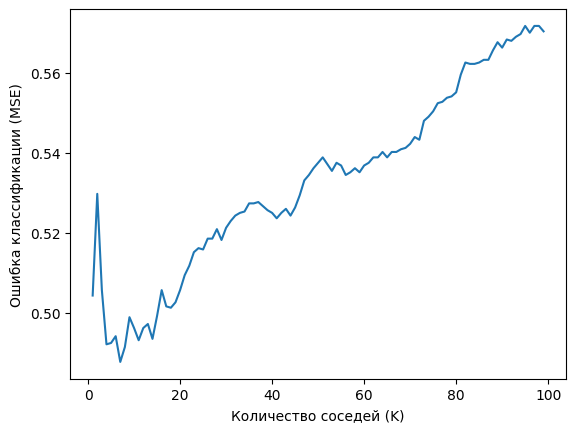

Оптимальные значения K:  [7]


In [75]:
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

# Выбор признаков и целевой переменной
features = ['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 
            'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']
X = df[features]  # Признаки
y = df['Style']   # Целевая переменная (стиль пива)

# Значения параметра K
k_list = list(range(1, 100))
# Пустой список для хранения значений точности
cv_scores = []

# В цикле проходим все значения k
for k in k_list:
    kmn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(kmn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1 - x for x in cv_scores]

# Строим график
plt.plot(k_list, MSE)
plt.xlabel('Количество соседей (K)')
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
k_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_k_min = []
for i in range(len(MSE)):
    if MSE[i] <= k_min:
        all_k_min.append(k_list[i])

# Печатаем все K, оптимальные для модели
print('Оптимальные значения K: ', all_k_min)